In [7]:
import numpy as np
import gym


In [8]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from random import seed
from sklearn import preprocessing
from torch.nn.init import kaiming_uniform_
seed(1)

In [9]:
def decay_schedule(init_value,
                   min_value,
                   decay_ratio,
                   max_steps,
                   log_start = -2,
                   log_base=10
):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    
    values = np.logspace(log_start,
                        0,
                        decay_steps,
                        base = log_base,
                        endpoint = True)[::-1]
    #print(value)
    values = (values - values.min())/(values.max() - values.min())
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [10]:
def generate_trajectory(env, select_action, Q, epsilon, max_steps=200): #generate single trajectory from start to terminal state
    done, trajectory = False, []
    state = env.reset()
    while not done:
        #print(max_steps)
        for t in range(max_steps):
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state)
            trajectory.append(experience)
            if done == True:
                break
            state = next_state
    return np.array(trajectory, np.object)

In [277]:
class linearApproximator(nn.Module):
    def __init__(self,state_shape,n_fc1,action_n):
        super(linearApproximator, self).__init__()
        self.input_size = state_shape
        self.n_fc1 = n_fc1
        self.out = action_n
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.fc1  = nn.Linear(self.input_size,self.n_fc1)
        self.fc2  = nn.Linear(self.n_fc1,self.n_fc1)
        self.fc3  = nn.Linear(self.n_fc1,self.out)
        self.to(self.device)
        
    def forward(self, state_shape):
        x = self.fc1(state_shape)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        out = self.fc3(x)
        return out

In [278]:
env = gym.make("CartPole-v0")


In [279]:
state

array([ 0.0139616 , -0.01148015, -0.04848314,  0.01808707])

In [280]:
def select_action(state, model, epsilon):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state = torch.tensor(state).float()
    with torch.no_grad():
        q_values= model(state).cpu().detach()
        q_values = q_values.data.numpy().squeeze()
    if np.random.rand() > epsilon:
        action = np.argmax(q_values)
    else:
        action = np.random.randint(len(q_values))
    return action

In [348]:
def nfq_(env,
         gamma=0.99,
         init_alpha=0.5,
         min_alpha=0.01,
         alpha_decay_ratio=0.5,
         init_epsilon=1.0,
         min_epsilon=0.1,
         epsilon_decay_ratio=0.5,
         k=40,
         sample_size=1024,
         n_ep=3000):
    
    epsilons = decay_schedule(
    init_epsilon,
    min_epsilon,
    epsilon_decay_ratio,
    n_ep)
    
    action_space = env.action_space.n
    state = env.reset()
    state_space = np.zeros((len(state)))
    
    model = linearApproximator(len(state), 100, action_space)
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)
    
    experience = []
    reward_per_ep = []
    for e in range(n_ep):
        state = env.reset()
        curr_reward = 0
        while True:
            action = select_action(state, model, epsilons[e])
            next_state, reward, done, info = env.step(action)
            curr_reward+=reward
            is_truncated = 'TimeLimit.truncated' in info and\
                                info['TimeLimit.truncated']
            is_failure = done and not is_truncated
            done = is_failure
            exp_tuple = (state, action, next_state, reward, done)
            experience.append(exp_tuple)
            if len(experience) == sample_size:
                for index in range(k):
                    for s, a, ns, r, d in experience:
                        t_next_states = ns
                        t_rewards = r
                        t_states = s
                        t_done = d
                        t_actions = a
                        
                        t_next_states = torch.tensor(t_next_states).float()
                        t_states = torch.tensor(t_states).float()
                        t_actions = torch.tensor(t_actions)#shoulb be int or long
                        t_rewards = torch.tensor(t_rewards).float()
                        t_done = torch.tensor(t_done).float()
                    
                        next_states_action_pairs = model(t_next_states).detach()
                        #print(next_states_action_pairs.max(), next_states_action_pairs.shape)
                        
                        next_states_action_pairs_max = next_states_action_pairs.max() #Q not sarsa
                        next_states_action_pairs_max *= 1 - t_done#look for terminal states
                   
                        state_action_pairs = model(t_states)
                        t_actions = t_actions.unsqueeze(0)
                        t_actions = t_actions.unsqueeze(0)
                        
                        #print(state_action_pairs, state_action_pairs.shape)
                        
                        state_action_pairs = state_action_pairs.unsqueeze(0)
                        
                        #print(state_action_pairs, state_action_pairs.shape)
                        #print(t_actions.shape, t_actions)
                        
                        state_action_pairs = state_action_pairs.gather(1, t_actions)
                        #print("gather: ", state_action_pairs)
                        td_target = t_rewards + gamma*next_states_action_pairs_max
                        #td_error = td_target - state_action_pairs
                        td_target = td_target.unsqueeze(0)
                        td_target = td_target.unsqueeze(0)
                        #print(state_action_pairs.shape, td_target.shape)
                        output = loss(state_action_pairs, td_target)
                        output.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                experience = []
            state = next_state
            if done == True:
                break
        reward_per_ep.append(curr_reward)
            
    return model, experience, reward_per_ep

In [ ]:
model, f_exp, rewards = nfq_(env, n_ep=3000)

In [ ]:
from matplotlib import pyplot as plt
x = []
y = []
for i,e in enumerate(rewards):
    y.append(i)
    x.append(e)

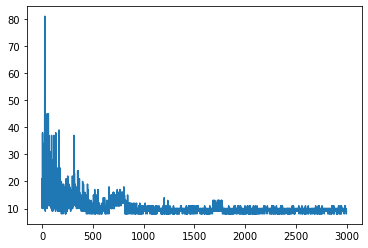

In [291]:
plt.plot(y, x)

In [ ]:
plt.plot(y, x)
#plt.show()

In [226]:
#ntwrk <class 'numpy.int64'>

In [49]:
exp = []
for t, i in enumerate(range(10)):
    v = (t,i)
    exp.append(v)

In [57]:
s = [s for s, a  in exp]

ValueError: not enough values to unpack (expected 3, got 2)

In [40]:
s = []
for k, v in exp:
    s.append(v)

In [41]:
type(s)

list

In [54]:
s

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [101]:
type(1)

int

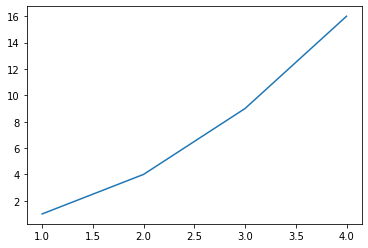

In [242]:
plt.plot([1, 2, 3, 4], [1, 4, 9, 16])